# PyCon talk running time experiments

Instructions for compilation:

1. Clone the repository and checkout the branch 3.11-instrumented:
   git clone https://github.com/sebawild/cpython.git
   git checkout 3.11-instrumented
2. Select the sorting method in Objects/listobject.c (lines 12 onwards):
   - Timsort: #define USE_TIMSORT
   - Powersort: #define USE_POWERSORT
   (At any time, only one of the two must be defined!)
   - For running time tests, also remove #define PRINT_INFO
3. Compile CPython with the following command:
   ./configure --enable-optimizations
   make
   make test
4. (optional) Create a venv for the compiled CPython:
   ./python -m venv venv
   source venv/bin/activate
   Check the version of Python:
   python --version


   python3 -m pip install -r requirements.txt

5. Run the script:
   python PyConRunningTimes.py
   (or ./python PyConRunningTimes.py if you are not using a venv)



In [1]:
import pandas as pd
from matplotlib import pyplot as plt

dir = '/home/swild/projects/nearly-optimal-mergesort/2023-talk-pycon/plots/liv/'


## Running time on integers

This is what is included in the slides for the Distinguished Lecture Series talk.
All were run on

The setup was as follows:

```python
seed = 2378956239523
n = 1000000


RNG = random.Random(seed)
inputs = [
    ("bad-example-cmps-1m ", lambda: bad_cmps_1m.bad_cmps_1000000),
    ("random-permutations ", lambda: Inputs.random_permutation(n, RNG)),
    ("random-permutations2", lambda: Inputs.random_permutation(n, RNG)),
    ("random-sqrtn-runs   ", lambda: Inputs.random_runs(n, int(n ** 0.5), RNG)),
    ("random-sqrtn-runs2  ", lambda: Inputs.random_runs(n, int(n ** 0.5), RNG)),
    ("random-sqrtn-runs3  ", lambda: Inputs.random_runs(n, int(n ** 0.5), RNG)),
    ("words-of-bible      ", lambda: Books.list_of_words_bible()),
    ("bad-example-cmps    ", lambda: bad_examples.bad_cmps_10k),
    ("bad-example-mc      ", lambda: bad_examples.bad_mc_10k),
]

times = timeit.repeat('sorted(lst)', globals=globals(), number=200, repeat=5)
# or was it 100 number?
```

The results were much slower for the first run of timsort, so I discarded this one.



In [3]:
def read(name):
	return pd.read_csv(dir + name, sep='\t',skiprows=10,header=None,names=['alg','iter','time'])

pow1 = read('PyConRunningTimes-powersort')
pow2 = read('PyConRunningTimes-powersort-run2')
pow3 = read('PyConRunningTimes-powersort-run3')
# pow4 = read('PyConRunningTimes-powersort-run4')
tim1 = read('PyConRunningTimes-timsort')
tim2 = read('PyConRunningTimes-timsort-run2')
tim3 = read('PyConRunningTimes-timsort-run3')
tim4 = read('PyConRunningTimes-timsort-run4')
all_pow = [pow1, pow2, pow3]
all_tim = [tim2, tim3, tim4] # take out tim1? ... seems outlier?
all_runs = all_pow + all_tim

algs = sorted(set(pow1['alg']))



def means(run):
	if type(run) is dict:
		return run
	return { alg:run[run['alg'] == alg]['time'].mean() for alg in algs }

def norm_means(run, all_runs):
	m = means(run)
	all_means = list(map(means, all_runs))
	m_all = { alg:sum([m[alg] for m in all_means]) for alg in algs }
	return { alg:m[alg]/m_all[alg] for alg in algs }

def avg(all_runs):
	all_means = list(map(means, all_runs))
	return { alg:sum([m[alg] for m in all_means])/len(all_means) for alg in algs }

# for alg in algs:
# 	print(alg)
# 	print(pow1[pow1['alg'] == alg]['time'].describe())

In [4]:
avg(all_pow)

{'bad-example-cmps    ': 0.04870682731270786,
 'bad-example-cmps-1m ': 8.333808650448917,
 'bad-example-mc      ': 0.05548568318287528,
 'random-permutations ': 56.53492874130607,
 'random-permutations2': 56.335987409576774,
 'random-sqrtn-runs   ': 32.47797638426224,
 'random-sqrtn-runs2  ': 33.23382777422667,
 'random-sqrtn-runs3  ': 32.8071899579217,
 'words-of-bible      ': 33.39799282960593}

In [5]:
avg(all_tim)

{'bad-example-cmps    ': 0.05900481827557083,
 'bad-example-cmps-1m ': 8.429353293652335,
 'bad-example-mc      ': 0.05512770153582092,
 'random-permutations ': 55.89324532027046,
 'random-permutations2': 56.68768925778568,
 'random-sqrtn-runs   ': 32.12084253057838,
 'random-sqrtn-runs2  ': 32.21738123322527,
 'random-sqrtn-runs3  ': 32.43625536436836,
 'words-of-bible      ': 33.41981231930355}

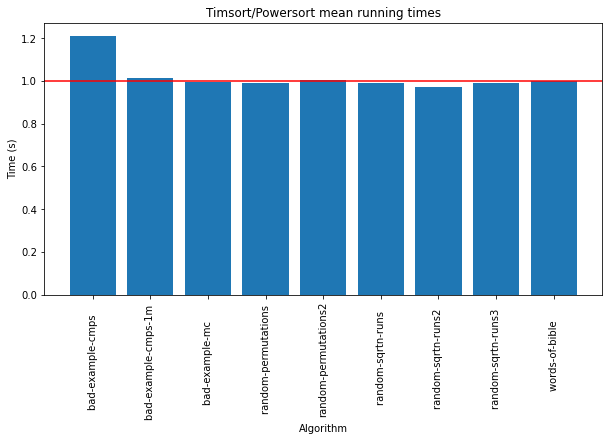

In [6]:
apow = avg(all_pow)
atim = avg(all_tim)
rel = { alg:atim[alg]/apow[alg] for alg in algs }
#plot
plt.figure(figsize=(10,5))
plt.title('Timsort/Powersort mean running times')
plt.xlabel('Algorithm')
plt.ylabel('Time (s)')
plt.bar(range(len(algs)), [rel[alg] for alg in algs])
plt.xticks(range(len(algs)), algs, rotation=90)
plt.axhline(1, color='r', linestyle='-')
plt.show()


The plot above is what is used in the slides; using the data below (with export to CSV and then manually generating the pgfplots commands ...)

In [7]:
pd.DataFrame(rel, index=['rel'])

,bad-example-cmps,bad-example-cmps-1m,bad-example-mc,random-permutations,random-permutations2,random-sqrtn-runs,random-sqrtn-runs2,random-sqrtn-runs3,words-of-bible
rel,1.211428,1.011465,0.993548,0.98865,1.006243,0.989004,0.969415,0.988693,1.000653


### Playing with other visualizations (outdated)

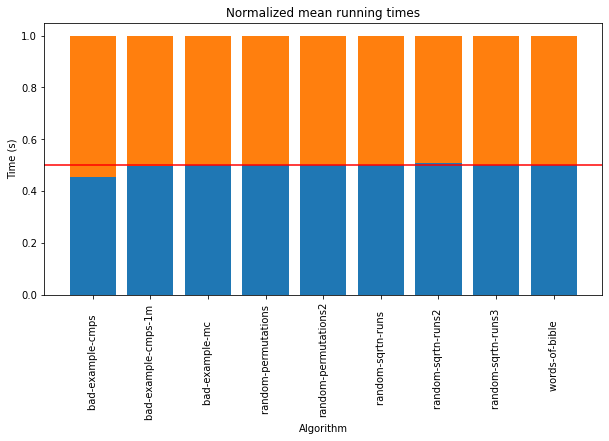

In [98]:
norm_avg_pow = norm_means(avg(all_pow), [avg(all_pow), avg(all_tim)])
norm_avg_tim = norm_means(avg(all_tim), [avg(all_pow), avg(all_tim)])

plt.figure(figsize=(10,5))
plt.title('Normalized mean running times')
plt.xlabel('Algorithm')
plt.ylabel('Time (s)')
plt.bar(range(len(algs)), [norm_avg_pow[alg] for alg in algs], label='Powersort')
plt.bar(range(len(algs)), [norm_avg_tim[alg] for alg in algs], bottom=[norm_avg_pow[alg] for alg in algs], label='Timsort')
plt.xticks(range(len(algs)), algs, rotation=90)
plt.axhline(0.5, color='r', linestyle='-')

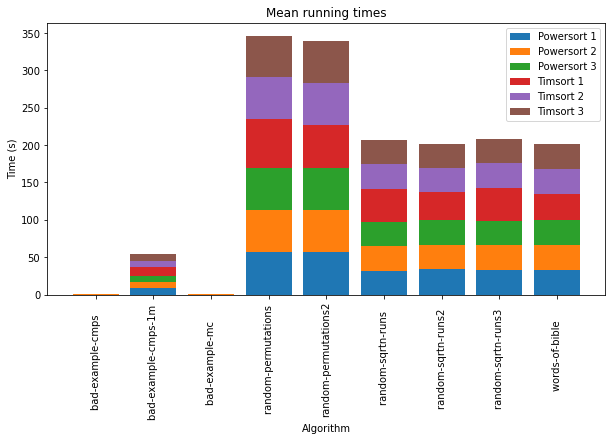

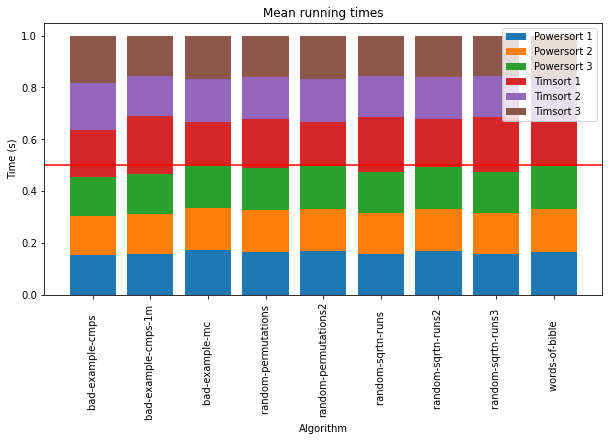

In [58]:
# Plot the means of four runs with algs on x axis and time, on y axis
def stacked_bar_plot(mpow1, mpow2, mpow3, mtim1, mtim2, mtim3, yline=None):
	plt.figure(figsize=(10,5))
	plt.title('Mean running times')
	plt.xlabel('Algorithm')
	plt.ylabel('Time (s)')
	plt.bar(range(len(algs)), [mpow1[alg] for alg in algs], label='Powersort 1')
	plt.bar(range(len(algs)), [mpow2[alg] for alg in algs], bottom=[mpow1[alg] for alg in algs], label='Powersort 2')
	plt.bar(range(len(algs)), [mpow3[alg] for alg in algs], bottom=[mpow1[alg] + mpow2[alg] for alg in algs], label='Powersort 3')
	plt.bar(range(len(algs)), [mtim1[alg] for alg in algs], bottom=[mpow1[alg] + mpow2[alg] + mpow3[alg] for alg in algs], label='Timsort 1')
	plt.bar(range(len(algs)), [mtim2[alg] for alg in algs], bottom=[mpow1[alg] + mpow2[alg] + mpow3[alg] + mtim1[alg] for alg in algs], label='Timsort 2')
	plt.bar(range(len(algs)), [mtim3[alg] for alg in algs], bottom=[mpow1[alg] + mpow2[alg] + mpow3[alg] + mtim1[alg] + mtim2[alg] for alg in algs], label='Timsort 3')
	plt.xticks(range(len(algs)), algs, rotation=90)
	if yline:
		plt.axhline(yline, color='r', linestyle='-')
	plt.legend()
	plt.show()


stacked_bar_plot(means(pow1), means(pow2), means(pow3), means(tim1), means(tim2), means(tim3))
stacked_bar_plot(norm_means(pow1, all_runs), norm_means(pow2, all_runs), norm_means(pow3, all_runs), norm_means(tim1, all_runs), norm_means(tim2, all_runs), norm_means(tim3, all_runs), yline=.5)
